# Generate random nodes

In [1]:
import random
import numpy as np

'''set the dimensions of the grid'''
size_width = 200
size_height = 200

'''set the number of nodes'''
population_size = 11

def generateNodes(width, height, nodesNumber):
    xs = np.random.randint(width, size=nodesNumber)
    ys = np.random.randint(height, size=nodesNumber)

    print('Nodes and coordinates:')
    print(np.column_stack((xs, ys)))
    return np.column_stack((xs, ys))

'''generate random list of nodes'''
nodes = generateNodes(size_width, size_height, population_size)


Nodes and coordinates:
[[102 140]
 [ 12 135]
 [ 92 119]
 [ 42  42]
 [155 170]
 [179 199]
 [ 33  32]
 [116  73]
 [103  83]
 [ 15  18]
 [ 46 196]]


# Functions to calculate initial weight

In [2]:
import math


def vectorToDistMatrix(coords):
    '''
    Create the distance matrix
    '''
    return np.sqrt((np.square(coords[:, np.newaxis] - coords).sum(axis=2)))


def nearestNeighbourSolution(dist_matrix):
    '''
    Computes the initial solution (nearest neighbour strategy)
    '''
    node = random.randrange(len(dist_matrix))
    result = [node]

    nodes_to_visit = list(range(len(dist_matrix)))
    nodes_to_visit.remove(node)

    while nodes_to_visit:
        nearest_node = min([(dist_matrix[node][j], j) for j in nodes_to_visit], key=lambda x: x[0])
        node = nearest_node[1]
        nodes_to_visit.remove(node)
        result.append(node)

    return result


# Bruteforce implementation (gets the most optim path)

In [3]:
from itertools import permutations
from datetime import datetime

def get_best_score_brute_force(nodes_matrix, paths):
    best_score = 0
    best_solution = []

    for path in paths:
        score = 0

        for i in range(1, len(path)):
            score += nodes_matrix[path[i-1]][i]

        score += nodes_matrix[path[i-1]][i]

        if best_score == 0 or score < best_score:
            best_score = score
            best_solution = path

    return (best_score, best_solution)

bruteforce_start_ts = datetime.now()
nodes_matrix = vectorToDistMatrix(nodes)
all_permutations = list(permutations(range(len(nodes_matrix[0]))))
bf_result = get_best_score_brute_force(nodes_matrix, all_permutations)
bruteforce_precessing_time = (datetime.now() - bruteforce_start_ts).total_seconds()

print("Bruteforce results:")
print("\tBest score:", bf_result[0])
print("\tBest path: ", bf_result[1])
print("\tExecution time:", bruteforce_precessing_time, "seconds")

Bruteforce results:
	Best score: 26.90724809414742
	Best path:  (1, 2, 6, 4, 5, 3, 7, 8, 9, 10, 0)
	Execution time: 264.638359 seconds


# Class for simulated annealing

In [4]:
import math
import matplotlib.pyplot as plt


class SimulatedAnnealing:
    def __init__(self, coords, temp, alpha, stopping_temp, stopping_iter):
        ''' animate the solution over time

            Parameters
            ----------
            coords: array_like
                list of coordinates
            temp: float
                initial temperature
            alpha: float
                rate at which temp decreases
            stopping_temp: float
                temerature at which annealing process terminates
            stopping_iter: int
                interation at which annealing process terminates

        '''

        self.coords = coords
        self.sample_size = len(coords)
        self.temp = temp
        self.alpha = alpha
        self.stopping_temp = stopping_temp
        self.stopping_iter = stopping_iter
        self.iteration = 1

        self.dist_matrix = vectorToDistMatrix(coords)
        self.curr_solution = nearestNeighbourSolution(self.dist_matrix)
        self.best_solution = self.curr_solution

        self.solution_history = [self.curr_solution]

        self.curr_weight = self.weight(self.curr_solution)
        self.initial_weight = self.curr_weight
        self.min_weight = self.curr_weight

        self.weight_list = [self.curr_weight]

        print('Intial weight (nearest neighbour algorithm): ', self.curr_weight)

    def weight(self, sol):
        '''
        Calcuate weight
        '''
        return sum([self.dist_matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def acceptance_probability(self, candidate_weight):
        '''
        Acceptance probability as described in:
        https://stackoverflow.com/questions/19757551/basics-of-simulated-annealing-in-python
        '''
        return math.exp(-abs(candidate_weight - self.curr_weight) / self.temp)

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        candidate_weight = self.weight(candidate)
        if candidate_weight < self.curr_weight:
            self.curr_weight = candidate_weight
            self.curr_solution = candidate
            if candidate_weight < self.min_weight:
                self.min_weight = candidate_weight
                self.best_solution = candidate

        else:
            if random.random() < self.acceptance_probability(candidate_weight):
                self.curr_weight = candidate_weight
                self.curr_solution = candidate

    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            candidate = list(self.curr_solution)
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)

            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])

            self.accept(candidate)
            self.temp *= self.alpha
            self.iteration += 1
            self.weight_list.append(self.curr_weight)
            self.solution_history.append(self.curr_solution)

        print('Minimum weight (simulated annealing algorithm): ', self.min_weight)
        
        improvement_percent = round((self.initial_weight - self.min_weight) / (self.initial_weight), 4) * 100
        print('Improvement: ', improvement_percent, '%')
        print()
        print('Solution:', self.best_solution)
        
        return (self.min_weight, self.best_solution, improvement_percent)

    def plotLearning(self):
        plt.plot([i for i in range(len(self.weight_list))], self.weight_list)
        line_init = plt.axhline(y=self.initial_weight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.min_weight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        plt.show()

# Main code

Intial weight (nearest neighbour algorithm):  667.9230282607025
Minimum weight (simulated annealing algorithm):  612.2441628128306
Improvement:  8.34 %

Solution: [2, 8, 7, 3, 6, 9, 1, 10, 5, 4, 0]
Execution time: 0.478718 seconds


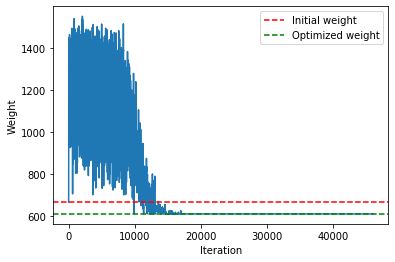

In [5]:
'''set the simulated annealing algorithm params'''
temperature = 10000
stopping_temp = 0.000001
alpha = 0.9995
stopping_iter = 20000000

'''run simulated annealing algorithm with 2-opt'''
sa = SimulatedAnnealing(nodes, temperature, alpha, stopping_temp, stopping_iter)
annealing_start_ts = datetime.now()
anneal_results = sa.anneal()
annealing_precessing_time = (datetime.now() - annealing_start_ts).total_seconds()
print("Execution time:", annealing_precessing_time, "seconds")

'''show the improvement over time'''
sa.plotLearning()    

# Statistics

In [6]:
print("Bruteforce results:")
print("\tBest score:", bf_result[0])
print("\tExecution time:", bruteforce_precessing_time, "seconds")

print()

print("Simulated Annealing results:")
print("\tBest score:", anneal_results[0])
print("\tBest path: ", anneal_results[1])
print("\tImprovement", anneal_results[2], "%")
print("\tExecution time:", annealing_precessing_time, "seconds")

Bruteforce results:
	Best score: 26.90724809414742
	Execution time: 264.638359 seconds

Simulated Annealing results:
	Best score: 612.2441628128306
	Best path:  [2, 8, 7, 3, 6, 9, 1, 10, 5, 4, 0]
	Improvement 8.34 %
	Execution time: 0.478718 seconds
